</style>
<h1  style="text-align:center;font-size:70px"> Data Challenge
    <h2 style="text-align:center">Face Recognition</h2>
    <br><br>
    <h2 style="text-align:left;font-size:20px">
        <u> Date:</u> January 2019 <br><br>
        <u> Author:</u> Mickael Lopes 
     </h2>
</h1>

# <b>Introduction</b>

## Fusion of algorithms for face recognition

The increasingly ubiquitous presence of biometric solutions and face recognition in particular in everyday life requires their adaptation for practical scenario. In the presence of several possible solutions, and if global decisions are to be made, each such single solution can be far less efficient than tailoring them to the complexity of an image.
<br><br>

In this challenge, the goal is to build a fusion of algorithms in order to construct the best suited solution for comparison of a pair of images. This fusion will be driven by qualities computed on each image. <br><br>


Comparing of two images is done in two steps. 1st, a vector of features is computed for each image. 2nd, a simple function produces a vector of scores for a pair of images. The goal is to create a function that will compare a pair of images based on the information mentioned above, and decide whether two images belong to the same person.<br><br>


You are provided a label set of training data and a test set without labels. You should submit a .csv file with labels for each entry of this test set.


## Dataset properties

<u>Training data:</u><br><br>

The training set consist of two files, xtrain_challenge.csv and xtest_challenge.csv.

File xtrain_challenge.csv contains one observation per row which contains following entries based on a pair of images, A and B say:<br>

    columns 1-14 - 14 qualities on image A;
    columns 15-28 - 14 qualities on image B;
    columns 29-36 - 8 matching scores between A and B.
<br><br>
File ytrain_challenge.csv contains one line with each entry corresponding to one observation in xtrain_challenge.csv, maintaining the order, and has '1' if a pair of images belong to the same person and '0' otherwise.

There are in total 3.196.465 training observations.<br><br>
<u>Test data:</u><br><br>

File xtest_challenge.csv has the same structure as file xtrain_challenge.csv.

There are in total 1.598.219 test observations.

## Performance criterion

The performance criterion is the prediction accuracy on the test set, which is a value between 0 and 1, the higher the better.

# <b>Report and algorithm</b>

In this chapter, we start by summarizing the strategy used for this problem and the scores obtained.  <br><br>

Then, a data exploration chapter to explain the relationship that we found in the data and how they lead us to our algorithm strategy.<br><br>

To finish, we present the implemented algorithm, which is commented and explained thorugh the code.

## Algorithm strategy

Our Algorithm mixed both graph thoery and staking strategy (Ramdom Forest and Gradient boosting). <br><br>

Our algorithm start by a graph analysis of train set to deduce match & unmatch in the testing set. At the end of this algorithm, we predicted 2/3 of the testing set with a precision of 1. (if we assume the assumptions explained in the next chapter as true and that the training set does not contains error). <br><br>

Then, we predict the last 1/3 of the testing set via a stacking strategy.

### Graph Strategy

Our graph strategy is based on the assumption that the set of 14 features representing an image is unique. Meaning that 2 different images could not have the same set of features values. I believe it is not a strong assumption due to the fact that most of the feature are float with a wild range. (and the algorithm score seems to confirm our assumption).<br><br>
Therefore, an image can be identified in the dataset via is set of values. Based on this idea, we realised that through 4.8 millions rows of our dataset (train and test), there is only ~130k images. <br><br>

Our graph algorithm is divided in two part : 
- The first part which "deduce" the match in the testing set 
- The second part which "deduce" the unmatch in the testing set.

For this part, we use the NetworkX Graph Library.

#### __Match Graph__

We start by labeling the different images in the dataset via a label encoder. 
Then, in a graph we implement all the match through the training set.
Therefore, we obtain a "matching" graph where : 
  - The nodes of the graph represents the id of the images (obtained via the label encoding). 
  - Each "edge" (connection between node) represents all the match through the training set. 
  
We obtain a graph like follow : <br>
<img src="Images/GraphImages.png">

_This images does not represent the training set (which has way more data). However, with this small, we will explain the logic behind the algorithm._

When the algorithm run through the testing set, it check if there is a path between the images that we are comparing. 

__If they are__, we tag the row as __"match".__ 

__If they not__, we tag the row as __unknown".__

_Indeed, if there is no path betweemn the two "images" nodes in the graph, it does not prove for certain they unmatch._

In our example, we established, based on the training set, that Image20 matchs with 17 which matchs with 4 , etc... 


Therefore, if we need to compare in the testing set Image 20 & 12, we will tag them as "match", because there is a path linking them. However, if we compare the Image0 and 22, we will tag them as "unknown".

#### __Unmatch Graph__

Based on the matching graph above, we create an index of "FaceIds" which correspond at the separated components from our "matching Graph". 

Let's take our previous example : 

<img src="Images/GraphImages.png">

Based on this graph, we identify 3 different components, therfore 3 different faces :  
- Face0: Images 22,26
- Face1: Images 20,17,4,3,18,12
- Face2: Images 5,0,27,29

Therefore, when we transform the training and testing set, for ImIdA equal to 22 or 26, we will put FaceIdA = 0 , etc.. 

_N.B. : At this stage, it is still possible than two different FaceId corresponds to the same face. However, this transformation allows us to easily identify all the images that correspond (for sure) at the same face._

Once this pretreatment is finished, we create a new "unmatch" graph where : 
- The nodes of the graph represents FaceID
- Each "edge" (connection between node) represents a unmatch relationship between the two faces.

Then, we transform the training and testing set to add the column FaceIdA and FaceIdB, in which we will map the corresponding FaceId 

Based on our example, we obtain a graph as follow : 

<img src="Images/UnmatchFace.png">

When the algorithm run through the testing set, it checks if there is __direct connection__ (meaning the two nodes are neighbor) between the FaceId that we are comparing. 

__If they are__, we tag the row as __"unmatch".__ 

__If they not__, we tag the row as __unknown".__

In our above example, it means that Face1 unmatch with Face0 and Face2. 

However, the comparison between Face0 and Face2 is unknown because there is no direct connection between the two.

#### __Conclusion__

Here are the statistics at this stage of algorithm : 
    - Number of predicted match : 441037
    - Number of predicted unmatch : 665182
    - Number of left to predict : 492000
    - We have predicted 0.692 % of the test dataset

### Stacking Strategy

For the stacking strategy, we created two classifier that we train on the X train set. 
Those two classifier are RandomForest and Xgboost.

We stack the prediction of those two classifiers with a threshold of 0,7. (It is the threshold that give us the best score of accuracy). 

Then we fuse the prediction of those classifiers to fill the "left to predict" part of our testing set

### Possible ameliorations

__Classifier tuning__

I did not had much time to feature engineer and tune the xgboost and random forest classifier that I used for the stacking strategy. 

Hyper tuning those classifier will give a better prediction on the left to predict part.

__Face vs Face prediction__

In this challenge, we do not know what is the relationship between the features attributes and the 's' columns.
However, if we knew the relationship between them, we could create a 'Face vs Face' algorithm by stacking the probability of all the 'matching' images. 

Let's take an example based on our previous graph example: 

<img src="Images/GraphImages.png">

Let's say in the testing set, we need to predict if Images 22 and 27 match or not. 
We know that Images 22 -> Face 0 and Image 27 -> Face 2. 

If we could create the 's' columns from the features values, we could then predict the 'matching' probability between all the images from Face 0 and Face 2. 

Meaning the matching probability between the images [Im22,Im29], [Im22,5], [Im26,Im5] , etc.. 

Then we calculate the mean of their probability to choose if Im22 matches Im27.

## Data Exploration

### Prerequisites

In [1]:
# import libraries
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import pickle
import time
import seaborn as sns
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score

/home/mickael/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [8]:
# Data Load
X_train_raw = pd.read_csv('InputData/xtrain_challenge.csv')
y_train_raw = pd.read_csv('InputData/ytrain_challenge.csv')
y_train_raw = np.array(y_train_raw).ravel()
X_test_raw = pd.read_csv('InputData/xtest_challenge.csv')

In [10]:
# Columns utilities
cols_A= ["fA1","fA2","fA3","fA4","fA5","fA6","fA7",
           "fA8","fA9","fA10","fA11","fA12","fA13","fA14"]
cols_B= ["fB1","fB2","fB3","fB4","fB5","fB6","fB7",
           "fB8","fB9","fB10","fB11","fB12","fB13","fB14"]
cols_s= ["s1","s2","s3","s4","s5","s6","s7","s8"]

### Quick Analysis

In [21]:
#Data types
X_train_raw.dtypes

fA1     float64
fA2     float64
fA3     float64
fA4       int64
fA5     float64
fA6     float64
fA7     float64
fA8     float64
fA9     float64
fA10    float64
fA11    float64
fA12    float64
fA13    float64
fA14    float64
fB1     float64
fB2     float64
fB3     float64
fB4       int64
fB5     float64
fB6     float64
fB7     float64
fB8     float64
fB9     float64
fB10    float64
fB11    float64
fB12    float64
fB13    float64
fB14    float64
s1      float64
s2      float64
s3      float64
s4      float64
s5      float64
s6      float64
s7      float64
s8      float64
dtype: object

In [12]:
# Quick analysis
X_train_raw[cols_A].describe()

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,fA11,fA12,fA13,fA14
count,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06
mean,3.123656e+00,7.200140e-01,8.895844e-02,2.938227e+01,9.112188e-01,4.165448e-03,8.456615e-02,1.323673e-01,2.970159e-02,-2.833317e-04,-6.684218e-02,5.518722e-02,-4.670538e-03,2.432554e+02
std,1.618458e+00,4.224322e-01,2.824698e-01,9.793075e+00,2.757797e-01,4.433567e-02,2.729676e-01,4.159110e-01,1.279389e-01,2.096133e-02,7.183572e-02,9.986129e-02,5.631579e-02,1.178723e+02
min,-4.500000e-01,0.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-2.550000e+00,-3.030000e+00,-3.000000e-01,-9.200000e-01,-4.600000e-01,-4.900000e-01,-3.087900e+02
25%,1.950000e+00,2.500000e-01,0.000000e+00,2.200000e+01,1.000000e+00,0.000000e+00,0.000000e+00,-2.000000e-02,-2.000000e-02,0.000000e+00,-1.100000e-01,0.000000e+00,-3.000000e-02,2.114900e+02
50%,3.390000e+00,1.000000e+00,0.000000e+00,2.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-02,0.000000e+00,-6.000000e-02,5.000000e-02,0.000000e+00,2.707000e+02
75%,4.380000e+00,1.000000e+00,0.000000e+00,3.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e-01,8.000000e-02,1.000000e-02,-2.000000e-02,1.100000e-01,2.000000e-02,3.175400e+02
max,7.940000e+00,1.000000e+00,1.000000e+00,7.400000e+01,1.000000e+00,1.000000e+00,1.000000e+00,2.500000e+00,7.600000e-01,2.600000e-01,4.200000e-01,5.700000e-01,3.900000e-01,4.814200e+02


In [13]:
X_train_raw[cols_B].describe()

,fB1,fB2,fB3,fB4,fB5,fB6,fB7,fB8,fB9,fB10,fB11,fB12,fB13,fB14
count,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06
mean,3.259105e+00,7.222405e-01,8.393031e-02,2.911277e+01,9.133351e-01,5.130911e-02,3.530586e-02,2.633891e-03,2.678805e-02,-8.387390e-06,-6.792530e-02,6.481959e-02,-4.888641e-03,2.477718e+02
std,1.599847e+00,4.208685e-01,2.744685e-01,9.734115e+00,2.750520e-01,2.146459e-01,1.814464e-01,4.390853e-01,1.183775e-01,1.989691e-02,6.964748e-02,9.894004e-02,5.770911e-02,1.221232e+02
min,-4.400000e-01,0.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-2.710000e+00,-2.750000e+00,-3.000000e-01,-5.500000e-01,-4.600000e-01,-4.200000e-01,-3.087900e+02
25%,2.140000e+00,2.700000e-01,0.000000e+00,2.200000e+01,1.000000e+00,0.000000e+00,0.000000e+00,-3.000000e-02,-2.000000e-02,0.000000e+00,-1.100000e-01,1.000000e-02,-3.000000e-02,2.214200e+02
50%,3.540000e+00,1.000000e+00,0.000000e+00,2.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-02,0.000000e+00,-6.000000e-02,5.000000e-02,0.000000e+00,2.766400e+02
75%,4.490000e+00,1.000000e+00,0.000000e+00,3.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e-02,7.000000e-02,1.000000e-02,-2.000000e-02,1.200000e-01,2.000000e-02,3.216600e+02
max,7.500000e+00,1.000000e+00,1.000000e+00,7.300000e+01,1.000000e+00,1.000000e+00,1.000000e+00,2.360000e+00,7.600000e-01,2.500000e-01,3.100000e-01,5.700000e-01,4.400000e-01,4.814200e+02


In [14]:
X_train_raw[cols_s].describe()

,s1,s2,s3,s4,s5,s6,s7,s8
count,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06
mean,3.874350e+03,2.434998e+03,4.200151e+03,4.242067e+03,3.488791e+03,3.399066e+03,3.509614e+03,3.745971e+03
std,2.063822e+03,2.272729e+02,2.954367e+03,2.127659e+03,1.360081e+03,1.363354e+03,1.066627e+03,1.548290e+03
min,1.212700e+03,1.511400e+03,7.218000e+02,1.133800e+03,6.682000e+02,7.200000e+02,1.358000e+03,7.107000e+02
25%,2.420300e+03,2.296300e+03,2.086200e+03,2.735400e+03,2.457200e+03,2.335000e+03,2.742600e+03,2.620100e+03
50%,3.062600e+03,2.439800e+03,3.073300e+03,3.402000e+03,3.063300e+03,2.999800e+03,3.151800e+03,3.218800e+03
75%,4.442500e+03,2.589300e+03,5.143800e+03,4.898800e+03,4.406800e+03,4.375500e+03,3.926300e+03,4.396900e+03
max,1.204420e+04,3.035900e+03,1.666650e+04,1.181290e+04,7.731000e+03,7.580100e+03,6.949500e+03,8.524900e+03


In [19]:
print("Matching images number : {}". format(sum(y_train_raw==1)))
print("Matching images percetange: {:.2f} %".format(100*
    sum(y_train_raw==1)/y_train_raw.shape[0]))

Matching images number : 913341
Matching images percetange: 28.57 %


__Conlusion:__ 

The different features seems to be completely unrelated to each other. Some are float, some are interger, and they do not have the same mean and standard deviation. So it will be hard to make sense out of them.
One find that is reassuring, it seems to be the same feature between image A and B since they have the same mean and standard deviation. 

### Correlation Analysis

Since we are comparing face of people, we could assume there is relationship in the feature when the images matches (meaning, it it the same face). 

Maybe a feature described the eyes color, then we should have the same feature value when two images matches. 

Let's plot 3 correlation matrix :
- One for the overall dataset 
- One with only the matching images in the dataset
- One with only the unmatching images in the dataset

In [23]:
# Mask 
mask_match = (y_train_raw == 1)

# Correlation matrix
corr_all = X_train_raw.corr()
corr_m = X_train_raw[mask_match].corr()
corr_um = X_train_raw[~mask_match].corr()

In [44]:
# Generate a mask for the down triangle of our correlation matrix
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

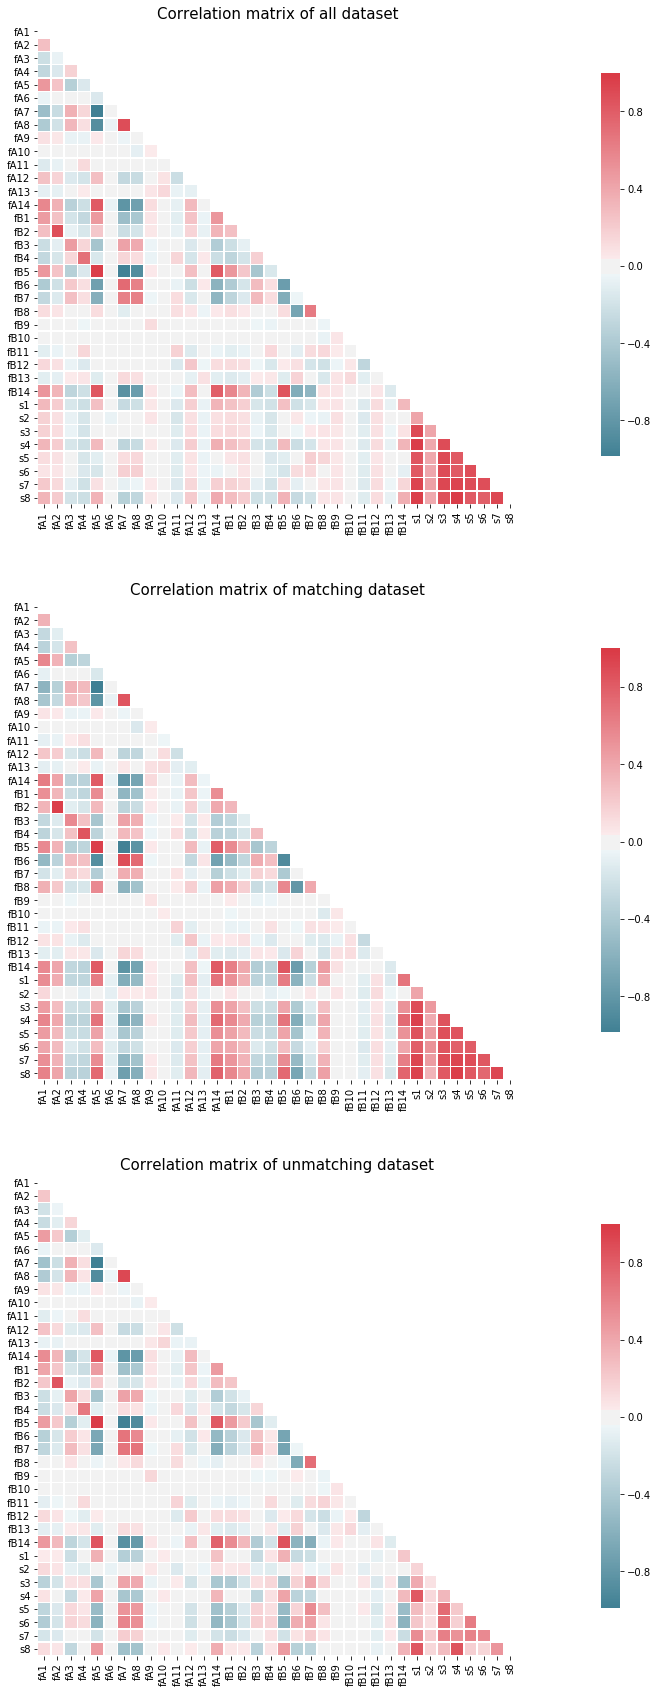

In [60]:
#Let's plot the figure
f, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(30,30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax =ax1 )
sns.heatmap(corr_m, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax =ax2 )
sns.heatmap(corr_um, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax =ax3 )

ax1.set_title("Correlation matrix of all dataset", fontsize= 15)
ax2.set_title("Correlation matrix of matching dataset", fontsize= 15)
ax3.set_title("Correlation matrix of unmatching dataset", fontsize= 15)
plt.show()

__Conclusion__ : 
From the entire dataset, we see there is a strong correlation among the same features. For example, there is a strong correlation between Feat5 and Feat7 (or 8), etc.. 
Maybe a PCA could be useful if we decide to go thourgh a classifier based on the features values. 

The most interesting point seems to be in the S values. Indeed, we see there is a strong correlation among the s values when the images are matching (which does not exist when they are not matching). This confirms that the s values give precious information about the matching probability. Let's plot a histogram diagram of the s values for the matching and unmatching set.

### Histogram Distribution Analysis

In [62]:
# Concatenate the X values for the s columns with the Y 
data = pd.concat([X_train_raw[cols_s],
                 pd.DataFrame(y_train_raw, columns = ["match"])], axis = 1 ,sort=False)

<Figure size 1080x1080 with 0 Axes>

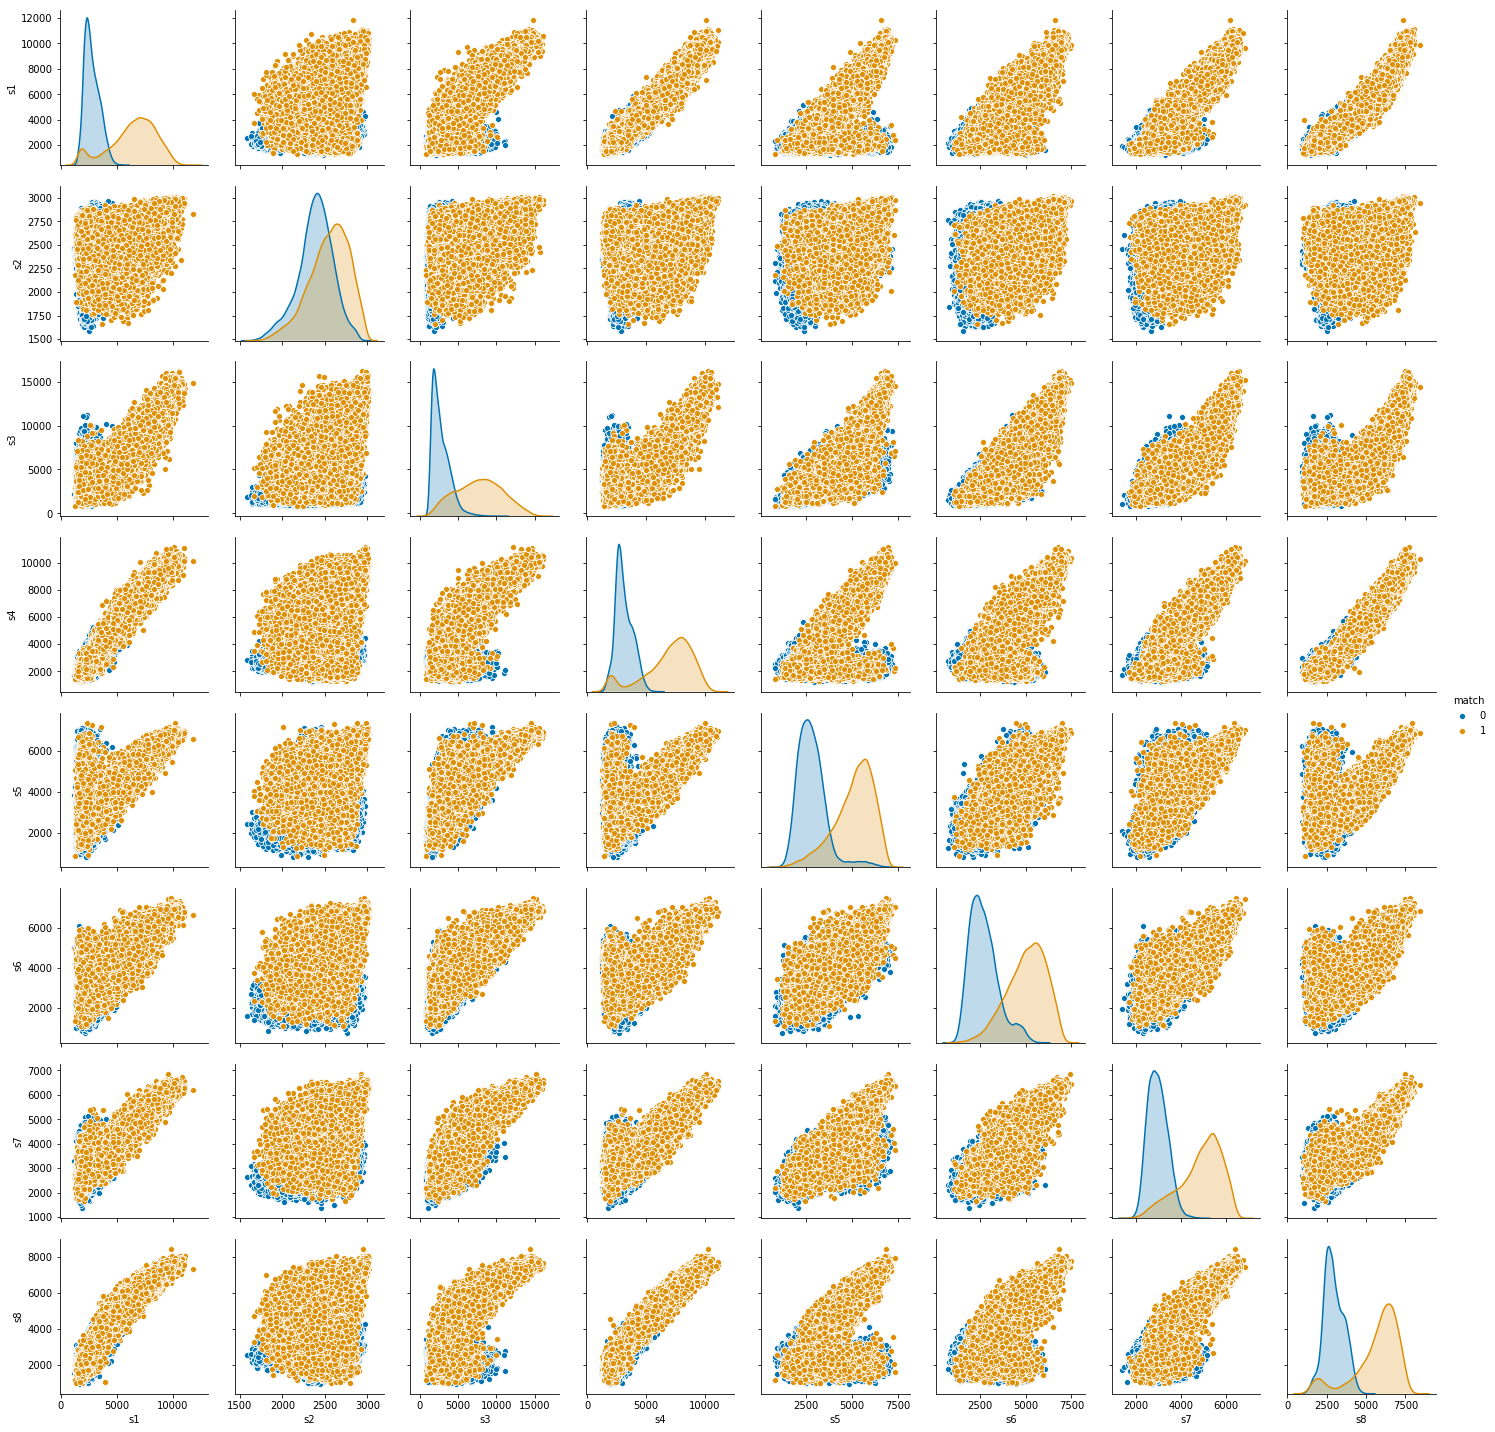

In [67]:
''' Plot of the s values for the match and unmatch rows. 
    We lot only on the 100k rows, just to see the distribution. 
    There is no need at this point to check on the entire 3.5 k values
'''
fig = plt.figure(figsize =(15,15))
sns.pairplot(data[:100000], hue = "match", vars = cols_s, palette = "colorblind")
plt.show()

We see clearly a difference of distribution for the match and unmatch values. 
Let's try to do the same analysis on the features columns. 

We will create new columns which will be featA - FeatB (the difference between the features values). Let's see the distribution of this values for the match and unmatch. 
We hope to see distinct distribution between the match and unmatch images. 

In [68]:
# Define the new columns
cols_f =["f1","f2","f3","f4","f5","f6","f7",
         "f8","f9","f10","f11","f12","f13","f14"]
#Create the diff  values
X_feat_diff = pd.DataFrame(X_train_raw[cols_A].values - X_train_raw[cols_B].values,
                    columns=cols_f)
# Concatenate with the match values
data2 = pd.concat([X_feat_diff,
                 pd.DataFrame(y_train_raw, columns = ["match"])], axis = 1 ,sort=False)

<Figure size 1080x504 with 0 Axes>

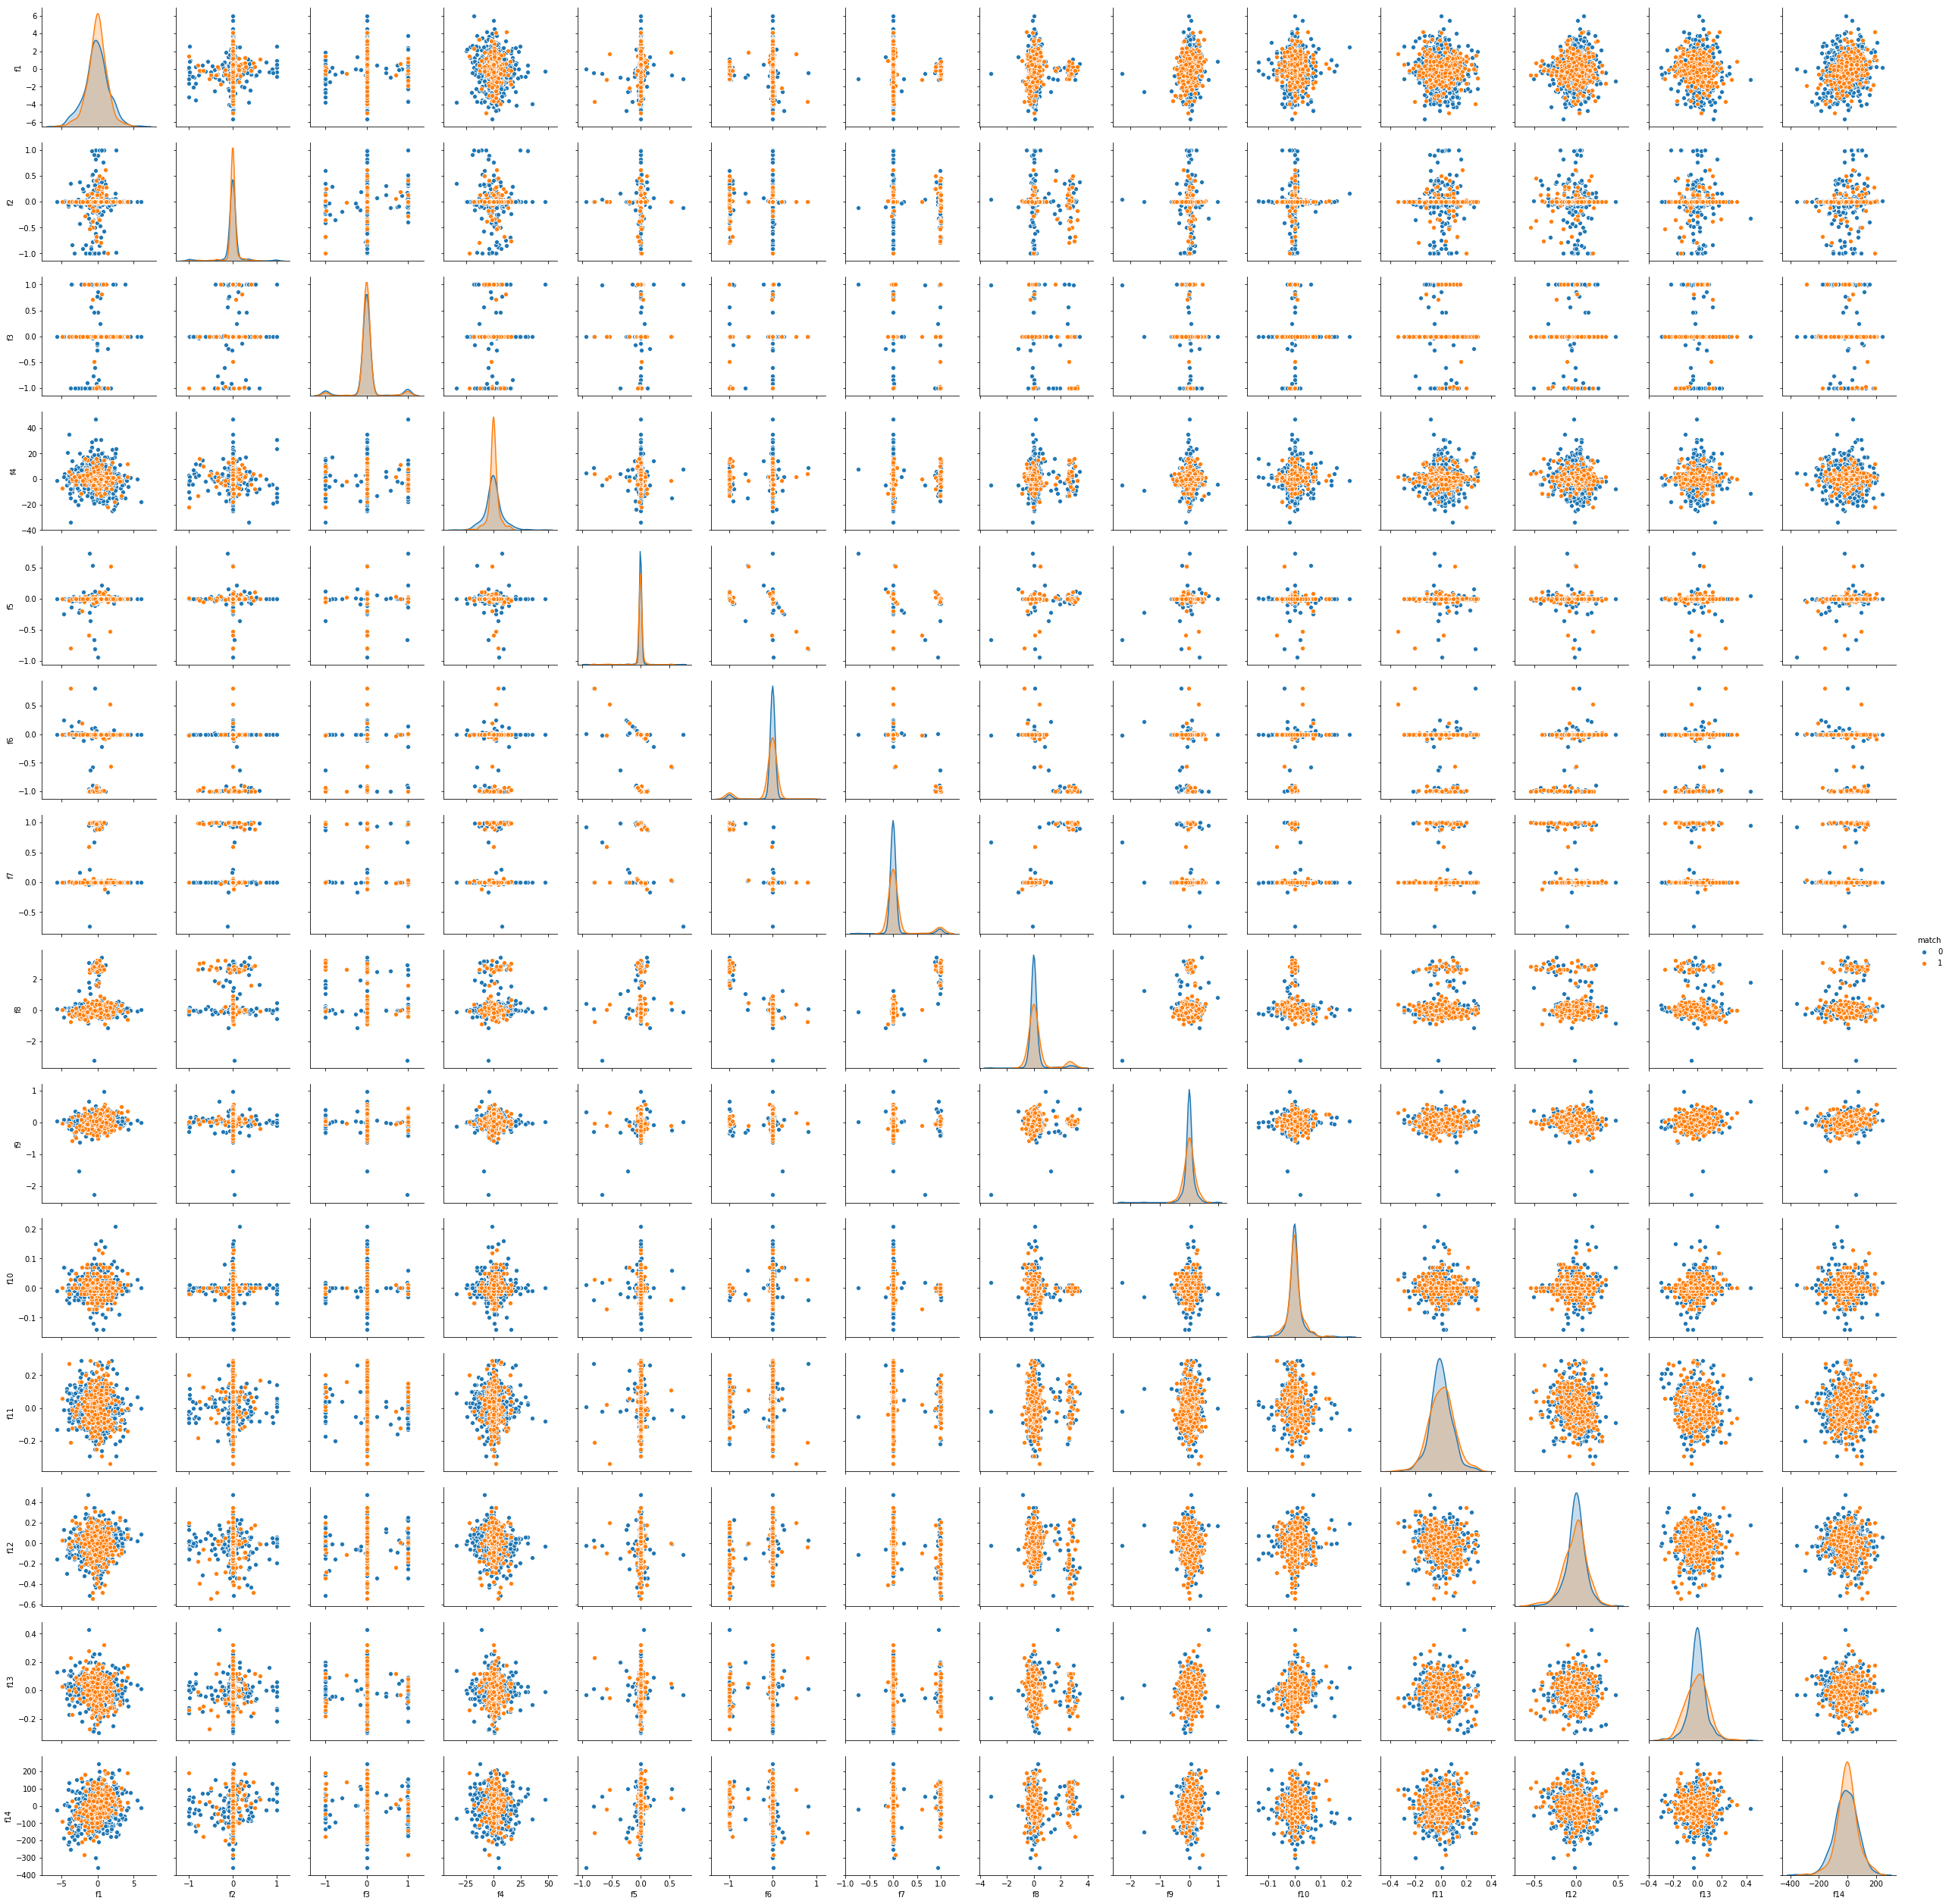

In [69]:
fig = plt.figure(figsize =(15,7))
sns.pairplot(data2[:1000], hue = "match", vars = cols_f[0])
plt.show()

__Conclusion__

The "s" columns clearly give some hints about the matching probability of the two images. In both their histograms repartition and their relationship between the features. 
However, the difference between the features attributes of the two images seems to be useless. 

Indeed, we do not seems to see any difference of repartition between the diff features values 

At this stage, it seems reasonable to use only the cols s in our future classifier since they seems to be the only ones with useful information. 

### Features columns analysis

As see below, the features columns does not give a lot of information about the matching probability. However, it seems harsh to throw all those values without doing anything with them.

Since we are comparing images, it seems reasonnable to think the same images comes back often in the dataset. Therefore, we decided to see the number of uniques set of features values.

In [71]:
# Create a copy of the X_train_raw dataset anddo transformation on it
X = X_train_raw.copy()

# We create a featA and featB  columns which is the aggreation of the features values
X["featA"] = X["fA1"].astype("str")+"_"+X["fA2"].astype("str")+"_"+ \
X["fA3"].astype("str")+"_"+X["fA4"].astype("str")+"_"+ \
X["fA5"].astype("str")+"_"+X["fA6"].astype("str")+"_"+ \
X["fA7"].astype("str")+"_"+X["fA8"].astype("str")+"_"+ \
X["fA9"].astype("str")+"_"+X["fA10"].astype("str")+"_"+ \
X["fA11"].astype("str")+"_"+X["fA12"].astype("str")+"_"+ \
X["fA13"].astype("str")+"_"+X["fA14"].astype("str")

X["featB"] = X["fB1"].astype("str")+"_"+X["fB2"].astype("str")+"_"+ \
X["fB3"].astype("str")+"_"+X["fB4"].astype("str")+"_"+ \
X["fB5"].astype("str")+"_"+X["fB6"].astype("str")+"_"+ \
X["fB7"].astype("str")+"_"+X["fB8"].astype("str")+"_"+ \
X["fB9"].astype("str")+"_"+X["fB10"].astype("str")+"_"+ \
X["fB11"].astype("str")+"_"+X["fB12"].astype("str")+"_"+ \
X["fB13"].astype("str")+"_"+X["fB14"].astype("str")

X.drop(cols_A, axis = 1, inplace = True)
X.drop(cols_B, axis = 1, inplace = True)
X.drop(cols_s, axis = 1, inplace = True)

X.head(5)

,featA,featB
0,3.77_1.0_1.0_41_1.0_0.0_0.0_-0.17_0.03_0.0_-0....,4.62_1.0_1.0_41_1.0_0.0_0.0_0.09_0.24_0.01_-0....
1,1.47_0.01_0.0_62_1.0_0.0_0.0_0.3_0.02_-0.01_-0...,0.85_0.0_0.0_51_1.0_0.0_0.0_-0.04_-0.1_0.02_-0...
2,4.93_1.0_0.0_21_1.0_0.0_0.0_0.0_0.16_0.0_-0.13...,4.34_0.99_0.0_26_1.0_0.0_0.0_-0.04_0.0_0.01_-0...
3,3.89_1.0_0.0_20_1.0_0.0_0.0_-0.35_0.09_-0.01_-...,4.54_1.0_0.0_24_1.0_0.0_0.0_-0.08_0.04_0.01_-0...
4,3.15_0.0_0.0_28_1.0_0.0_0.0_0.08_-0.08_-0.01_-...,4.25_0.0_0.0_22_1.0_0.0_0.0_-0.04_0.01_0.0_-0....


In [74]:
# we concat the 2 columns together and see the number of uniqueness
df_feat_tr=pd.concat([X["featA"],X["featB"]],axis = 0)
df_feat_tr.drop_duplicates(inplace=True)

print("The number of images in the training set is: {}".format(df_feat_tr.shape[0]))

The number of images in the training set is: 122726


Therefore, there is only 122k unique images in that are being compared in the training dataset. 
We decided to do the same evaluation for the testing set. And also to see if the training and testing set shares some images. 

In [75]:
# Create a copy of the X_test_raw dataset anddo transformation on it
X = X_test_raw.copy()

# We create a featA and featB  columns which is the aggreation of the features values
X["featA"] = X["fA1"].astype("str")+"_"+X["fA2"].astype("str")+"_"+ \
X["fA3"].astype("str")+"_"+X["fA4"].astype("str")+"_"+ \
X["fA5"].astype("str")+"_"+X["fA6"].astype("str")+"_"+ \
X["fA7"].astype("str")+"_"+X["fA8"].astype("str")+"_"+ \
X["fA9"].astype("str")+"_"+X["fA10"].astype("str")+"_"+ \
X["fA11"].astype("str")+"_"+X["fA12"].astype("str")+"_"+ \
X["fA13"].astype("str")+"_"+X["fA14"].astype("str")

X["featB"] = X["fB1"].astype("str")+"_"+X["fB2"].astype("str")+"_"+ \
X["fB3"].astype("str")+"_"+X["fB4"].astype("str")+"_"+ \
X["fB5"].astype("str")+"_"+X["fB6"].astype("str")+"_"+ \
X["fB7"].astype("str")+"_"+X["fB8"].astype("str")+"_"+ \
X["fB9"].astype("str")+"_"+X["fB10"].astype("str")+"_"+ \
X["fB11"].astype("str")+"_"+X["fB12"].astype("str")+"_"+ \
X["fB13"].astype("str")+"_"+X["fB14"].astype("str")

X.drop(cols_A, axis = 1, inplace = True)
X.drop(cols_B, axis = 1, inplace = True)
X.drop(cols_s, axis = 1, inplace = True)

df_feat_test=pd.concat([X["featA"],X["featB"]],axis = 0)
df_feat_test.drop_duplicates(inplace=True)

In [76]:
print("The number of images in the testing set is: {}".format(df_feat_test.shape[0]))

The number of images in the testing set is: 122165


In [78]:
df_feat = pd.concat([df_feat_test, df_feat_tr], axis=0)
df_feat.drop_duplicates(inplace=True)

print("The number of images in the training and testing set is: {}".format(
    df_feat.shape[0]))
print("The number of new images in the testing set is: {}".format(
    df_feat.shape[0] - df_feat_test.shape[0]))

The number of images in the training and testing set is: 122780
The number of new images in the testing set is: 615


__Conclusion__

The training and testing set shares a lot of images. 
It is then possible, via transitivity, to deduce in the testing set the matching between images based on the match in the training set (see algorithm strategy for more details).

### Conclusion

From our evaluation analysis, only the 's' columns seems to give useful information for the prediction. 

However, we can refine the 'features' columns to uniquely identifies the images. When we do this, we see that the training and testing set shares the same images. Therefore, we could deduce part of the match / unmatch in the testing set via transitivity (if A matches B and B matchs C --> A matches C) 

This is how I get the idea for my graph algorithm

## Score Report

At the end of our algorithm, we obtain a score of : 
    0.99948192364

## Algorithm

### Label Encoding of the images

In [5]:
def _create_list_of_images_feat(X_raw):
    X = X_raw.copy()
    
    X["featA"] = X["fA1"].astype("str")+"_"+X["fA2"].astype("str")+"_"+ \
    X["fA3"].astype("str")+"_"+X["fA4"].astype("str")+"_"+ \
    X["fA5"].astype("str")+"_"+X["fA6"].astype("str")+"_"+ \
    X["fA7"].astype("str")+"_"+X["fA8"].astype("str")+"_"+ \
    X["fA9"].astype("str")+"_"+X["fA10"].astype("str")+"_"+ \
    X["fA11"].astype("str")+"_"+X["fA12"].astype("str")+"_"+ \
    X["fA13"].astype("str")+"_"+X["fA14"].astype("str")

    X["featB"] = X["fB1"].astype("str")+"_"+X["fB2"].astype("str")+"_"+ \
    X["fB3"].astype("str")+"_"+X["fB4"].astype("str")+"_"+ \
    X["fB5"].astype("str")+"_"+X["fB6"].astype("str")+"_"+ \
    X["fB7"].astype("str")+"_"+X["fB8"].astype("str")+"_"+ \
    X["fB9"].astype("str")+"_"+X["fB10"].astype("str")+"_"+ \
    X["fB11"].astype("str")+"_"+X["fB12"].astype("str")+"_"+ \
    X["fB13"].astype("str")+"_"+X["fB14"].astype("str")

    X.drop(cols_A, axis = 1, inplace = True)
    X.drop(cols_B, axis = 1, inplace = True)
    X.drop(cols_s, axis = 1, inplace = True)
    
    df=pd.concat([X["featA"],X["featB"]],axis = 0)
    df.drop_duplicates(inplace=True)
    return df

In [6]:
# Transform Data and Test set to create unique values
X_train_images = _create_list_of_images_feat(X_train_raw)
X_test_images = _create_list_of_images_feat(X_test_raw)
X_all_images = pd.concat([X_train_images, X_test_images], axis = 0 )
X_all_images.drop_duplicates(inplace=True)

In [7]:
print("The number of uniques images in train and test dataset is : {}".format(X_all_images.shape[0]))

The number of uniques images in train and test dataset is : 122780


In [8]:
# Create a label encoder to transform the images label in unique values
le_images = LabelEncoder()
le_images.fit(X_all_images)

LabelEncoder()

In [14]:
def label_encoding(X_raw, le): 
    X = X_raw.copy()
    
    X["featA"] = X["fA1"].astype("str")+"_"+X["fA2"].astype("str")+"_"+ \
    X["fA3"].astype("str")+"_"+X["fA4"].astype("str")+"_"+ \
    X["fA5"].astype("str")+"_"+X["fA6"].astype("str")+"_"+ \
    X["fA7"].astype("str")+"_"+X["fA8"].astype("str")+"_"+ \
    X["fA9"].astype("str")+"_"+X["fA10"].astype("str")+"_"+ \
    X["fA11"].astype("str")+"_"+X["fA12"].astype("str")+"_"+ \
    X["fA13"].astype("str")+"_"+X["fA14"].astype("str")

    X["featB"] = X["fB1"].astype("str")+"_"+X["fB2"].astype("str")+"_"+ \
    X["fB3"].astype("str")+"_"+X["fB4"].astype("str")+"_"+ \
    X["fB5"].astype("str")+"_"+X["fB6"].astype("str")+"_"+ \
    X["fB7"].astype("str")+"_"+X["fB8"].astype("str")+"_"+ \
    X["fB9"].astype("str")+"_"+X["fB10"].astype("str")+"_"+ \
    X["fB11"].astype("str")+"_"+X["fB12"].astype("str")+"_"+ \
    X["fB13"].astype("str")+"_"+X["fB14"].astype("str")

    X.drop(cols_A, axis = 1, inplace = True)
    X.drop(cols_B, axis = 1, inplace = True)
    
    X["ImidA"] = le.transform(X["featA"])
    X["ImidB"] = le.transform(X["featB"])

    X.drop(["featA","featB"], axis = 1 , inplace=True)
    
    return X[["ImidA","ImidB"] + cols_s]

In [15]:
# Tranfrom the training and testing set to get rid of the "feat" columns and replace 
# them by the unique id
X_train_lbl = label_encoding(X_train_raw, le_images)
X_test_lbl = label_encoding(X_test_raw, le_images)

In [16]:
# X_train lbl
X_train_lbl.head()

,ImidA,ImidB,s1,s2,s3,s4,s5,s6,s7,s8
0,91121,110930,2464.1,2117.2,1760.6,2241.3,1900.3,1462.8,2344.9,1949.8
1,32480,20733,3975.9,2640.9,2672.6,4233.8,3357.9,2224.0,3341.1,3611.5
2,115312,105373,3401.1,2644.3,2514.2,3551.3,3019.7,3414.7,2763.6,3252.2
3,94285,109395,2418.6,2659.6,2742.1,3422.4,2602.6,2784.0,2697.4,2505.1
4,72553,103319,2309.1,2164.0,1755.6,2377.4,1994.6,2147.6,1902.9,2599.5


In [17]:
# X_test_lbl
X_test_lbl.head()

,ImidA,ImidB,s1,s2,s3,s4,s5,s6,s7,s8
0,5008,95333,3954.3,2346.6,3739.3,3958.2,3140.3,2874.3,3485.2,4055.4
1,43777,74167,3564.5,2327.0,2124.8,3625.2,2476.3,3458.5,3423.5,3355.9
2,105608,100342,2220.9,2591.8,2547.8,2430.7,2142.2,2244.0,2817.6,2295.3
3,104971,69932,3505.8,2529.5,3203.4,4154.9,2929.7,2162.2,3463.8,3240.9
4,119420,86747,7018.9,2732.8,6628.9,7127.1,5498.2,3899.8,4494.8,5643.7


Let's save those 2 dataset as feature engineered dataset.

In [19]:
X_train_lbl.to_csv('InterData/xtrain_labelised.csv')
X_test_lbl.to_csv('InterData/xtest_labelised.csv')

Now, we will work on those 2 transformed datasets to labelised the "face" that we can identify in this dataset.

### Label Encoding of the images

In [20]:
# create a nxGraph and load all the matching in the graph
# This will be our "match" Graph
G = nx.Graph()

In [21]:
# Add all the match connection on the graph
mask_match = (y_train_raw==1)
# Graph of match
G = nx.from_pandas_edgelist(X_train_lbl[mask_match], "ImidA", 'ImidB')

In [30]:
# Add the nodes in the graph
# We have 122780 so it is the number of nodes
images_ids = np.arange(122780)
G.add_nodes_from(images_ids)

In [ ]:
''' 
    we create a mapping dataframe between the images and Faces.
    To do so, for each images id, we use the graph to identify 
    all the other images ids that it matchs in the graph. 
    We will after order those set (ascending) and LabelEncode on this values

'''
df_map_id_faceid = pd.DataFrame(images_ids, columns = ["images_ids"])
df_map_id_faceid["matching_set"] = df_map_id_faceid.apply(lambda x : 
                                                         str(sorted(nx.node_connected_component(G,x["images_ids"]))) , axis = 1) 

In [56]:
df_map_id_faceid.head(10)

,images_ids,matching_set
0,0,[0]
1,1,"[1, 24285]"
2,2,"[2, 70064, 79731, 84484, 93380]"
3,3,"[3, 48146]"
4,4,"[4, 61258]"
5,5,[5]
6,6,[6]
7,7,[7]
8,8,[8]
9,9,"[9, 239, 532, 3024, 4610, 8883, 10591, 11737, ..."


The images which are matched (by transivity) will have the same matching_set values. 
We will label encode the "matching_set" columns to create a list of "face_ids" 
We will then map in Xtrain and Xtest the corresponding images to the corresponding face id

In [60]:
# Create the face labelEncode
le_face = LabelEncoder()
df_map_id_faceid["face_ids"] = le_face.fit_transform(df_map_id_faceid["matching_set"])

In [61]:
df_map_id_faceid.head(10)

,images_ids,matching_set,face_ids
0,0,[0],0
1,1,"[1, 24285]",1
2,2,"[2, 70064, 79731, 84484, 93380]",9364
3,3,"[3, 48146]",13493
4,4,"[4, 61258]",19194
5,5,[5],30494
6,6,[6],35711
7,7,[7],40493
8,8,[8],44681
9,9,"[9, 239, 532, 3024, 4610, 8883, 10591, 11737, ...",44682


Let's transform the X_train_lbl and X_test_lbl with the face_ids instead of the images id ("iDx')

In [112]:
number_of_face = np.unique(df_map_id_faceid["face_ids"].values).shape[0]
print("Based on our graph study, there is {} different faces in the dataset so far".format(number_of_face))

Based on our graph study, there is 48543 different faces in the dataset so far


In [82]:
mapping = dict(df_map_id_faceid[['images_ids', 'face_ids']].values)
X_train_lbl['FaceIdA'] = X_train_lbl.ImidA.map(mapping)
X_train_lbl['FaceIdB'] = X_train_lbl.ImidB.map(mapping)
X_test_lbl['FaceIdA'] = X_test_lbl.ImidA.map(mapping)
X_test_lbl['FaceIdB'] = X_test_lbl.ImidB.map(mapping)

In [70]:
X_train_lbl.head(5)

,ImidA,ImidB,s1,s2,s3,s4,s5,s6,s7,s8,FaceIdA,FaceIdB
0,91121,110930,2464.1,2117.2,1760.6,2241.3,1900.3,1462.8,2344.9,1949.8,12542,3491
1,32480,20733,3975.9,2640.9,2672.6,4233.8,3357.9,2224.0,3341.1,3611.5,14797,9640
2,115312,105373,3401.1,2644.3,2514.2,3551.3,3019.7,3414.7,2763.6,3252.2,43866,35373
3,94285,109395,2418.6,2659.6,2742.1,3422.4,2602.6,2784.0,2697.4,2505.1,45445,10663
4,72553,103319,2309.1,2164.0,1755.6,2377.4,1994.6,2147.6,1902.9,2599.5,11042,1142


Let's make a quick check of our engineering on the training set. If we did it correctly, we will see that all images that match in the training set should have the same FaceId for A and B (and for unmatch it will be different)

In [83]:
X_train_lbl[mask_match].head(10)

,ImidA,ImidB,s1,s2,s3,s4,s5,s6,s7,s8,FaceIdA,FaceIdB
5,24518,112373,3601.8,2421.2,2181.6,5404.0,4235.0,3235.5,2912.1,5100.5,21058,21058
12,110624,115300,4382.2,2180.4,3788.3,5390.6,4101.9,3679.9,3883.0,4676.9,15359,15359
16,116170,88704,7702.9,2416.4,8842.6,8151.7,6009.1,5195.0,5035.3,5607.9,4254,4254
17,84056,97034,5753.0,2411.8,3844.0,5341.1,4561.9,4147.9,4023.7,4580.4,9239,9239
18,9939,1781,7981.1,2617.2,12027.8,8786.8,6411.7,5632.6,5711.0,6954.8,8522,8522
22,120234,115006,6815.1,2751.2,6861.3,7526.6,5181.0,5288.8,5189.4,6265.0,30988,30988
25,114346,112113,9626.6,2763.7,11407.1,9470.4,6716.3,6335.4,5964.3,6875.3,9122,9122
27,17765,5887,2483.5,2701.4,3968.9,2171.9,4685.0,5331.5,4360.3,2157.2,10223,10223
29,117958,66335,5083.7,2336.9,5598.2,6165.3,4093.6,4566.1,4507.2,5648.5,19985,19985
32,109743,51284,7679.9,2641.6,7037.3,8271.7,5687.1,5450.6,5373.1,6234.7,18907,18907


In [84]:
X_train_lbl[~mask_match].head(10)

,ImidA,ImidB,s1,s2,s3,s4,s5,s6,s7,s8,FaceIdA,FaceIdB
0,91121,110930,2464.1,2117.2,1760.6,2241.3,1900.3,1462.8,2344.9,1949.8,12542,3491
1,32480,20733,3975.9,2640.9,2672.6,4233.8,3357.9,2224.0,3341.1,3611.5,14797,9640
2,115312,105373,3401.1,2644.3,2514.2,3551.3,3019.7,3414.7,2763.6,3252.2,43866,35373
3,94285,109395,2418.6,2659.6,2742.1,3422.4,2602.6,2784.0,2697.4,2505.1,45445,10663
4,72553,103319,2309.1,2164.0,1755.6,2377.4,1994.6,2147.6,1902.9,2599.5,11042,1142
6,29426,102757,2382.8,2295.3,1648.2,2078.5,2050.1,2009.1,2586.3,2512.8,12606,8526
7,109535,120800,2598.2,2756.7,2683.6,2602.6,2900.7,2584.2,3248.1,2731.1,26705,8721
8,41425,41413,3564.0,2322.8,3285.9,3097.6,2517.0,2870.2,2560.5,3283.7,20080,8698
9,85961,86908,3723.5,2723.9,4009.9,4554.6,4032.4,2732.6,3490.2,3934.6,43053,34127
10,109829,42752,2982.5,2107.8,2765.4,3345.8,2973.7,2794.5,2889.0,3424.0,3025,15062


In [85]:
X_test_lbl.head()

,ImidA,ImidB,s1,s2,s3,s4,s5,s6,s7,s8,FaceIdA,FaceIdB
0,5008,95333,3954.3,2346.6,3739.3,3958.2,3140.3,2874.3,3485.2,4055.4,25015,46791
1,43777,74167,3564.5,2327.0,2124.8,3625.2,2476.3,3458.5,3423.5,3355.9,21385,32589
2,105608,100342,2220.9,2591.8,2547.8,2430.7,2142.2,2244.0,2817.6,2295.3,22154,14390
3,104971,69932,3505.8,2529.5,3203.4,4154.9,2929.7,2162.2,3463.8,3240.9,42215,15029
4,119420,86747,7018.9,2732.8,6628.9,7127.1,5498.2,3899.8,4494.8,5643.7,31866,31866


Our transformation seems correct. let's save those new set in X_train_flbl and X_test_flbl

In [89]:
X_train_flbl = X_train_lbl[["FaceIdA", "FaceIdB"]+ cols_s]
X_test_flbl = X_test_lbl[["FaceIdA", "FaceIdB"]+ cols_s]

In [90]:
X_train_flbl.to_csv('InterData/xtrain_Facelabelised.csv')
X_test_flbl.to_csv('InterData/xtest_Facelabelised.csv')

Let's now work on this new dataset for the prediction

### Prediction of Y test based on the Graph

In [7]:
# create a nxGraph which will represent the unmatch of the different faces
G_u = nx.Graph()

In [12]:
# Graph of unmatch faces
G_u = nx.from_pandas_edgelist(X_train_flbl[~mask_match], "FaceIdA", 'FaceIdB')

In [13]:
# Add the nodes in the graph
# We have 48543 faces identifie,  which is the numebr of nodes
face_ids = np.arange(48543)
G_u.add_nodes_from(face_ids)

In [14]:
def _prediction_transivity(row):
    """
        For each row, the function will check 
        if the FaceIdA == FaceIdB. If yes, it is a match
        
        if the FaceIds are  different, we check if the two corresponding 
        node are connected in the 'unmacth' Graph
    """
    faceA = row["FaceIdA"]
    faceB = row["FaceIdB"]
    if faceA == faceB: 
        row["y_pred"] = 1
    else : 
        if faceA in G_u[faceB]:
            row["y_pred"] = 0
    return row

In [15]:
# Create a y_pred columns with a default value of -1
X_test_flbl["y_pred"] = -1

In [16]:
start = time.time() 
X_test_flbl = X_test_flbl.apply(_prediction_transivity, axis = 1)
end = time.time()
print("The process took {:.4f} seconds".format(end-start))

The process took 126.4907 seconds


In [128]:
print("Number of predicted match : {}".format(sum(X_test_flbl["y_pred"] == 1)))
print("Number of predicted unmatch : {}".format(sum(X_test_flbl["y_pred"] == 0)))
print("Number of left to predict : {}".format(sum(X_test_flbl["y_pred"] == -1)))
print("We have predicted {:.3f} % of the test dataset".format(1 - sum(X_test_flbl["y_pred"] == -1)/ X_test_flbl.shape[0]))

Number of predicted match : 441037
Number of predicted unmatch : 665182
Number of left to predict : 492000
We have predicted 0.692 % of the test dataset


In [17]:
X_test_flbl['y_pred'].to_csv('InterData/xtest_graphPrediction.csv', index = False)

### Prediction of left to predict

#### GradientBoostingClassifier and RandomForest Classifier

For this part, we use a gradient boosting model that we train on the training set. (all the columns)

We use the xgboost library and skilearn library. 

I train both those classifier on different computer and save the model in .pkl file. 
(There is no interest of showing how to make a classifier)
Therefore, I will just upload the model and predict the X test. 

In [106]:
pkl_filename_xgb0 = "xgboost_stage1_model.pkl"
with open(pkl_filename_xgb0, 'rb') as file:  
    xgb0 = pickle.load(file)
pkl_filename_rf0 = "randomForest_stage1_model.pkl"
with open(pkl_filename_rf0, 'rb') as file:  
    rf0 = pickle.load(file)

/home/mickael/anaconda3/envs/Graph/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mickael/anaconda3/envs/Graph/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mickael/anaconda3/envs/Graph/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.20.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [107]:
# Parameters of Xgboost
xgb0.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.8, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=nan, n_estimators=1024,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)>

In [108]:
# Parameters of Xgboost
rf0.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)>

In [110]:
y_pred_xgb = xgb0.predict_proba(X_test_raw)
y_pred_rf0 = rf0.predict_proba(X_test_raw)

In [116]:
y_clas_prediction = pd.DataFrame(np.c_[y_pred_xgb,y_pred_rf0], 
                                columns = ["xgb_soft_0", "xgb_soft_1", "rf_soft_0", "rf_soft_1"])

In [117]:
y_clas_prediction.head()

,xgb_soft_0,xgb_soft_1,rf_soft_0,rf_soft_1
0,9.999636e-01,3.638171e-05,0.942072,0.057928
1,9.999989e-01,1.131604e-06,0.989372,0.010628
2,1.000000e+00,9.405607e-12,0.996507,0.003493
3,9.790099e-01,2.099006e-02,0.979538,0.020462
4,8.344650e-07,9.999992e-01,0.000777,0.999223


In [118]:
y_clas_prediction.to_csv('InterData/y_pred_classifier_xgb+rf.csv',index=False)

#### Algorithm prediction assembling

For this algorithm, we will create a fuse prediction of our two classifier 
by choosing the values that both classifier predicted as "match"

In [217]:
# Weigth of our classifier [xgb,rf]
weigth = [0.5, 0.5]
threshold =0.7

mask_pred_stack = ((weigth[0]*y_clas_prediction['xgb_soft_1'] +
                    weigth[1]*y_clas_prediction['rf_soft_1']) >threshold)
y_clas_prediction['y_stack'] =  0
y_clas_prediction.loc[mask_pred_stack,'y_stack']=1
y_clas_prediction.head()

,xgb_soft_0,xgb_soft_1,rf_soft_0,rf_soft_1,y_stack
0,9.999636e-01,3.638171e-05,0.942072,0.057928,0
1,9.999989e-01,1.131604e-06,0.989372,0.010628,0
2,1.000000e+00,9.405607e-12,0.996507,0.003493,0
3,9.790099e-01,2.099006e-02,0.979538,0.020462,0
4,8.344650e-07,9.999992e-01,0.000777,0.999223,1


In [218]:
print("Number of predicted match : {}".format(sum(y_clas_prediction["y_stack"] == 1)))
print("Number of predicted unmatch : {}".format(sum(y_clas_prediction["y_stack"] == 0)))
print("The match percentage : {:.2f} %".format(
    100* sum(y_clas_prediction["y_stack"] == 1) / y_clas_prediction["y_stack"].shape[0]))

Number of predicted match : 420819
Number of predicted unmatch : 1177400
The match percentage : 26.33 %


Now we fuse those prediction with the prediction of our graph

In [219]:
def _function_fuse_threshold(X_test_graph, X_to_fuse):
    y_pred_final = pd.DataFrame(np.c_[X_test_graph.values,X_to_fuse.values],
                            columns = ["Y_Graph", "Y_stacking"])
    mask_unpredict_match = (y_pred_final['Y_stacking'] ==1)& \
        (y_pred_final['Y_Graph']==-1)
    mask_unpredict_unmatch = (y_pred_final['Y_stacking'] ==0 )&\
        (y_pred_final['Y_Graph']==-1)
    y_pred_final['y_pred_final'] = y_pred_final['Y_Graph']
    y_pred_final.loc[mask_unpredict_match,'y_pred_final'] = 1 
    y_pred_final.loc[mask_unpredict_unmatch,'y_pred_final'] = 0 
    return y_pred_final

In [220]:
y_test_final = _function_fuse_threshold(X_test_flbl['y_pred'], 
                                        y_clas_prediction['y_stack'])

In [221]:
print("Number of predicted match : {}".format(sum(y_test_final["y_pred_final"] == 1)))
print("Number of predicted unmatch : {}".format(sum(y_test_final["y_pred_final"] == 0)))
print("The match percentage : {:.2f} %".format(
    100* sum(y_test_final["y_pred_final"] == 1) / y_test_final.shape[0]))

Number of predicted match : 455652
Number of predicted unmatch : 1142567
The match percentage : 28.51 %


In [222]:
y_test_final["y_pred_final"].astype('int64').to_csv('OutputData/y_pred_final.csv',index=False)